In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pandas as pd
from StockTradingRLEnv_Abhi import StockTradingEnv, INITIAL_ACCOUNT_BALANCE
import matplotlib.pyplot as plt


In [9]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        # x = torch.nn.functional.softmax(x, dim=-1)
        return x

The agent only has two options either to buy or sell. I tried with hold but that led to model being stuck at self netowrth neither to buy nor sell sometimes so that delta remains 0. Each action is either buy 1 stock or sell 1 stock. The model with time was able to beat or equate the stock prices.

In [10]:
class Agent:
    def __init__(self, state_dim, is_eval=False, model_name=""):
        self.state_dim = state_dim
        self.action_dim = 2  # 0: Buy, 1: Sell
        self.memory = deque(maxlen=200)
        
        self.batch_size = 32
        self.tau = 0.0001
        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.999
        self.is_eval = is_eval
        
        self.model = DQN(state_dim, self.action_dim)
        self.target_model = DQN(state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        
        if self.is_eval:
            self.model.load_state_dict(torch.load(f'saved_models/{model_name}'))
            self.target_model.load_state_dict(torch.load(f'saved_models/{model_name}'))
        else:    
            self.update_target_model()
        
    def update_target_model(self):
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            action_type = random.randrange(0,self.action_dim)  # 0 for buy, 1 for sell, 2 for hold
            return action_type
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        # print("q_values",q_values)
        action_type = torch.argmax(q_values[0]).item()
        # print("action_type",action_type, "epsilon",self.epsilon)
        return action_type
        
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            
            # Predict Q-values for current state
            target = self.model(state).detach().clone()
            
            if done:
                target[0][action] = reward
            else:
                # Select the action using the main model
                next_action = torch.argmax(self.model(next_state)[0]).item()
                
                # Evaluate the action using the target model
                t = self.target_model(next_state)[0]
                target[0][action] = reward + self.gamma * t[next_action].item()
            
            # Get the current Q-values
            output = self.model(state)
            
            # Calculate loss and perform backpropagation
            loss = self.loss_fn(output, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        # Update epsilon for the epsilon-greedy strategy
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        
    def save(self, name):
        torch.save(self.model.state_dict(), f'saved_models/{name}.pth')

Helper Functions

In [11]:
def plot_buy_sell(env, trades):
    plt.figure(figsize=(12,3.5))

    # Plot stock price with a thinner line
    plt.plot(env.df['Date'], env.df['Close'], label='Stock Price', linewidth=1, color='b')

    # Extract buy and sell trades
    buy_trades = [trade for trade in trades if trade[1] == 0]
    sell_trades = [trade for trade in trades if trade[1] == 1]

    plt.scatter(env.df.loc[[trade[0] for trade in sell_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in sell_trades], 'Close'], 
                marker='v', color='r', s=40, label='Sell', alpha=1)
    
    plt.scatter(env.df.loc[[trade[0] for trade in buy_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in buy_trades], 'Close'], 
                marker='^', color='g', s=40, label='Buy', alpha=0.6)


    # Labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Trades')

    # Show legend
    plt.legend()

    # Show plot
    plt.show()
    

In [12]:
def plot_networth(env, networths):
    """
    Plot the net worth of the trading bot over time and compare it with the net worth
    if the initial amount was fully invested in the stock.
    """
    dates = env.df['Date']
    stock_prices = env.df['Close']
    
    # Calculate the hypothetical net worth if the initial balance was fully invested in the stock
    initial_stock_price = stock_prices.iloc[0]
    shares_if_fully_invested = INITIAL_ACCOUNT_BALANCE / initial_stock_price
    hypothetical_networths = shares_if_fully_invested * stock_prices
    
    plt.figure(figsize=(12,3.5))
    plt.plot(dates, hypothetical_networths, label='Hypothetical Net Worth (Fully Invested in Stock)', linewidth=1, color='r')
    plt.plot(dates[:len(networths)], networths, label='Actual Net Worth', linewidth=1, color='b')
    
    plt.xlabel('Date')
    plt.ylabel('Net Worth')
    plt.title('DDQN Trading Bot Net Worth Over Time')
    plt.legend()
    plt.show()

The plots and all the results are for the GSPC_2018 dataset

In [13]:
# df = pd.read_csv('./data/AAPL.csv')
# df = pd.read_csv('./data/^GSPC_2010-2015.csv')
# df = pd.read_csv('./data/^GSPC_2014.csv')
df = pd.read_csv('./data/^GSPC_2018.csv')
# df = pd.read_csv('./data/FB_2018.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.reset_index(drop=True)

env = StockTradingEnv(df, render_mode='human')
state_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
agent = Agent(state_dim=state_dim)

episodes = 20

Time: 100 episode: 1/20 score: 19505.512056466083
Time: 200 episode: 1/20 score: 19924.427376387153
Episode 1/20 - NetWorth: 19875.350771953676


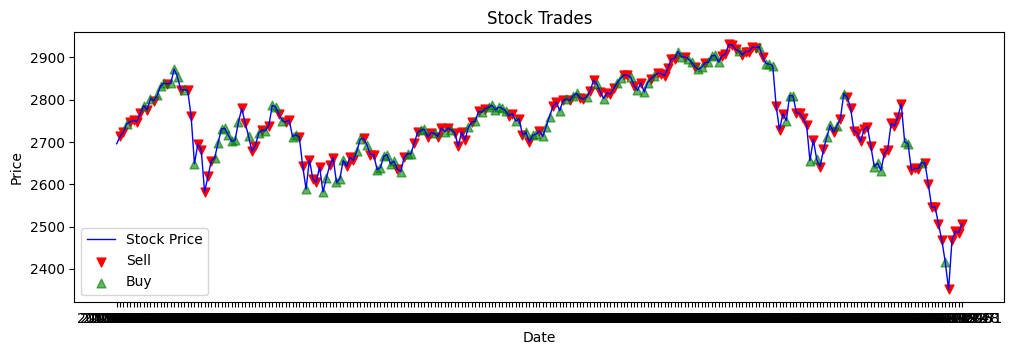

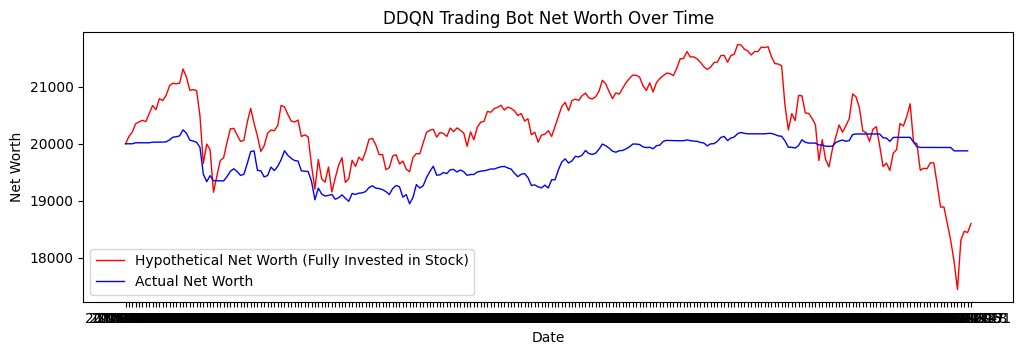

Time: 100 episode: 2/20 score: 20270.92904894315
Time: 200 episode: 2/20 score: 20550.1350067796
Episode 2/20 - NetWorth: 19795.19884724588


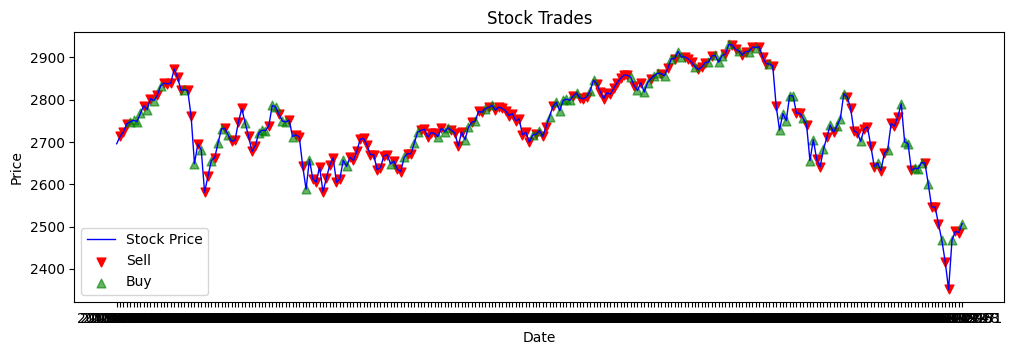

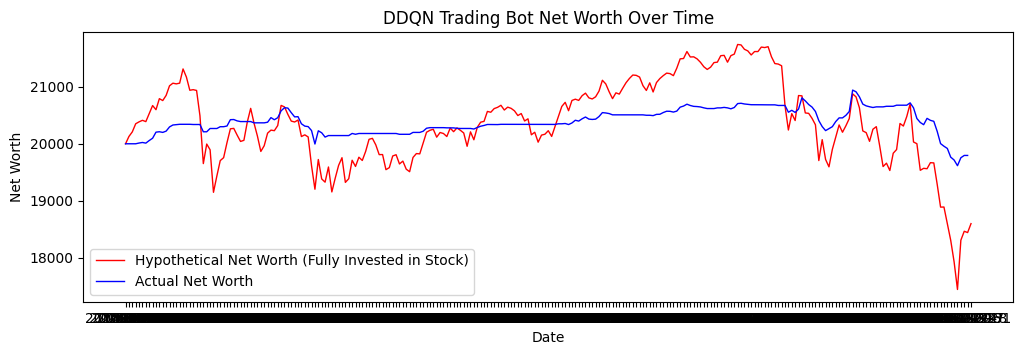

Time: 100 episode: 3/20 score: 19841.728973629994
Time: 200 episode: 3/20 score: 19965.906334297946
Episode 3/20 - NetWorth: 18384.441900295446


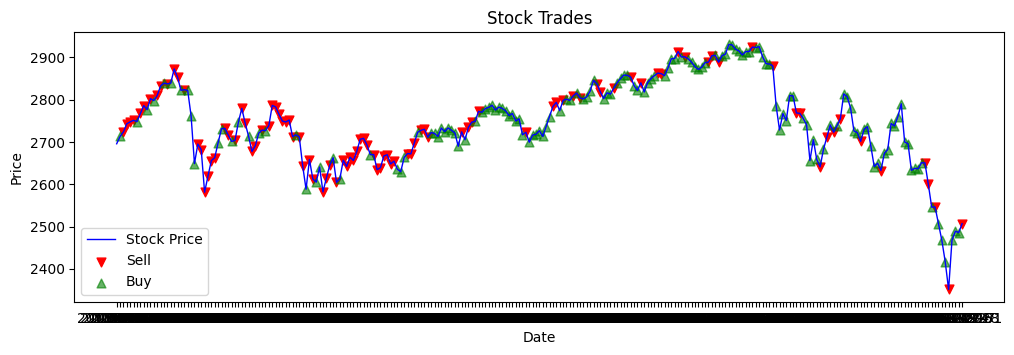

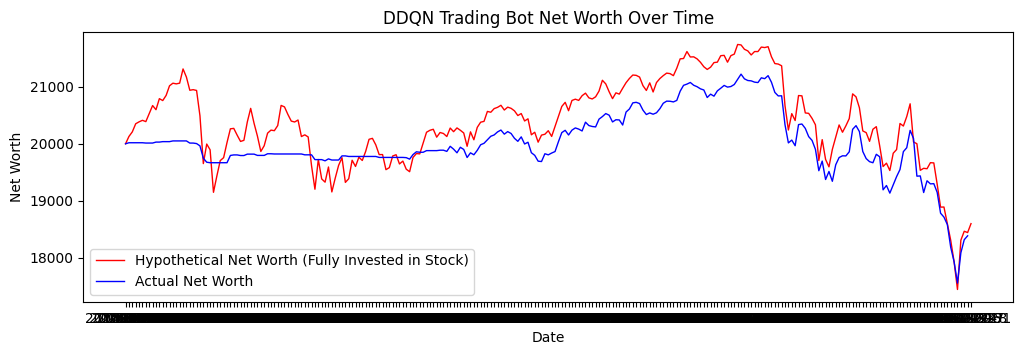

Time: 100 episode: 4/20 score: 19632.058641808955
Time: 200 episode: 4/20 score: 19514.5783216492
Episode 4/20 - NetWorth: 19139.502190417035


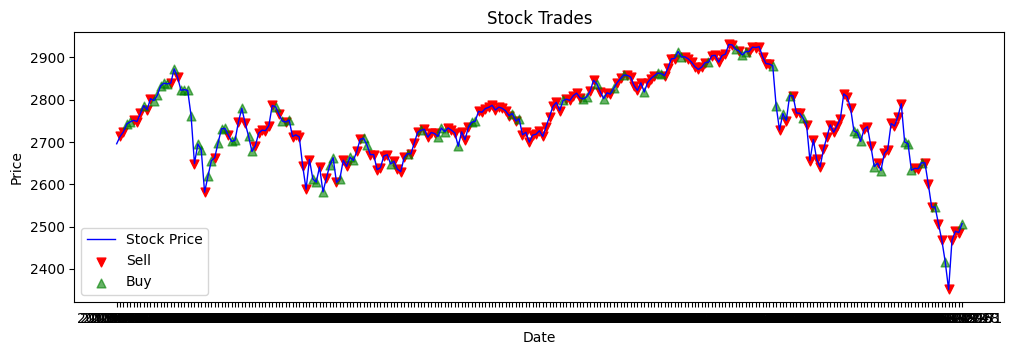

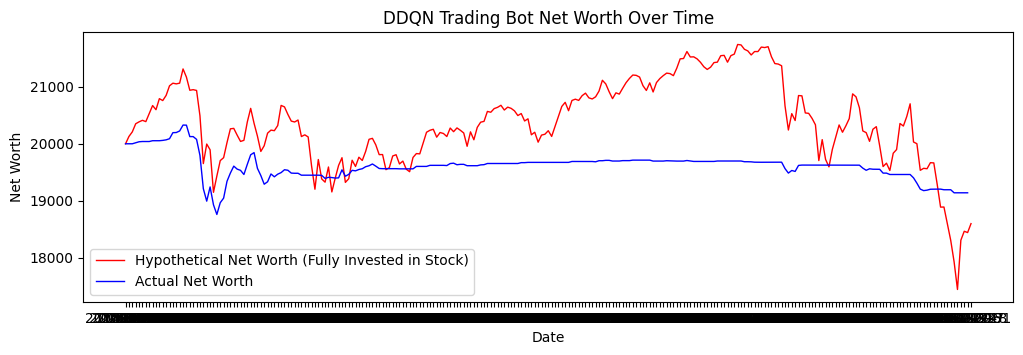

Time: 100 episode: 5/20 score: 19736.365300027574
Time: 200 episode: 5/20 score: 20357.96791147147
Episode 5/20 - NetWorth: 20392.58324534669


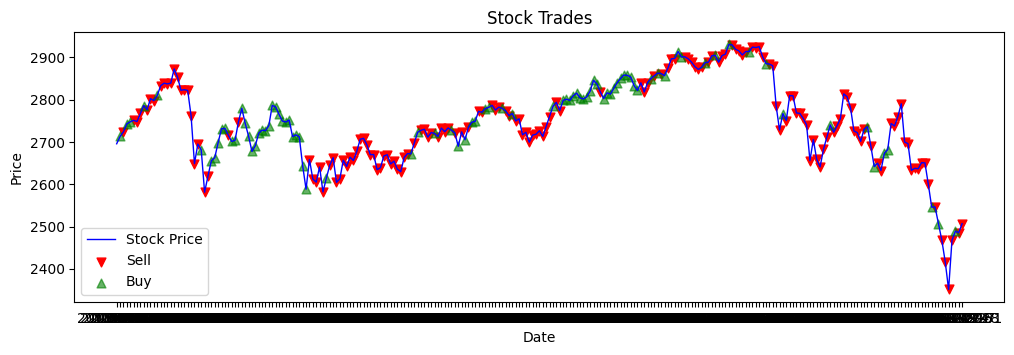

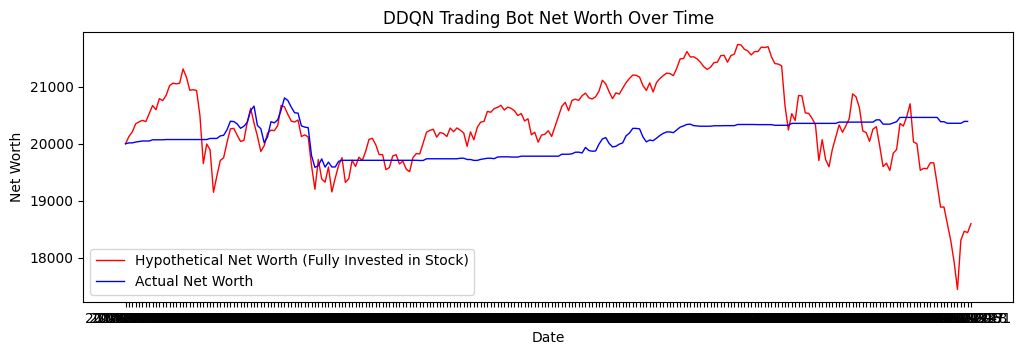

Time: 100 episode: 6/20 score: 20067.91302776907
Time: 200 episode: 6/20 score: 20158.916168393618
Episode 6/20 - NetWorth: 18597.604274762045


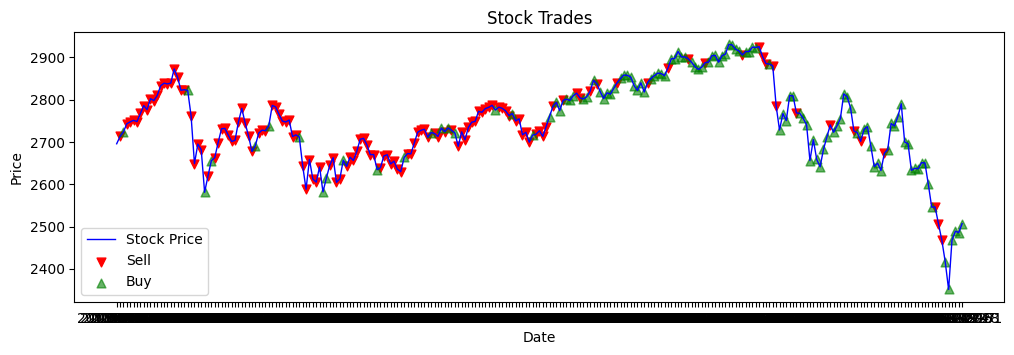

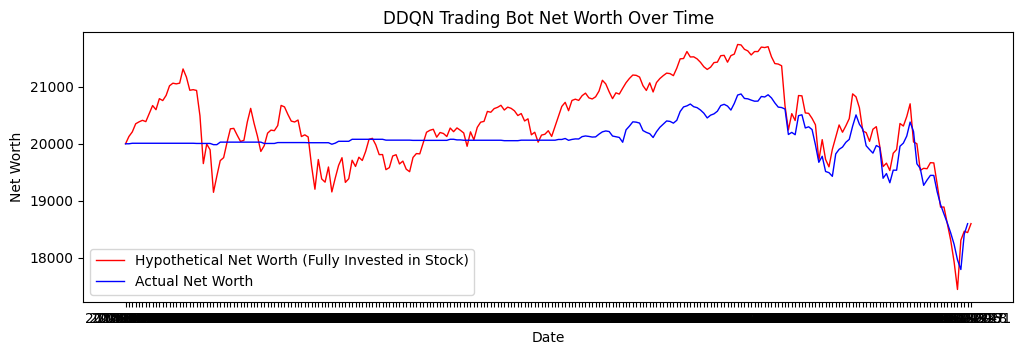

Time: 100 episode: 7/20 score: 20859.941215208673
Time: 200 episode: 7/20 score: 21370.616047947733
Episode 7/20 - NetWorth: 19975.285107765492


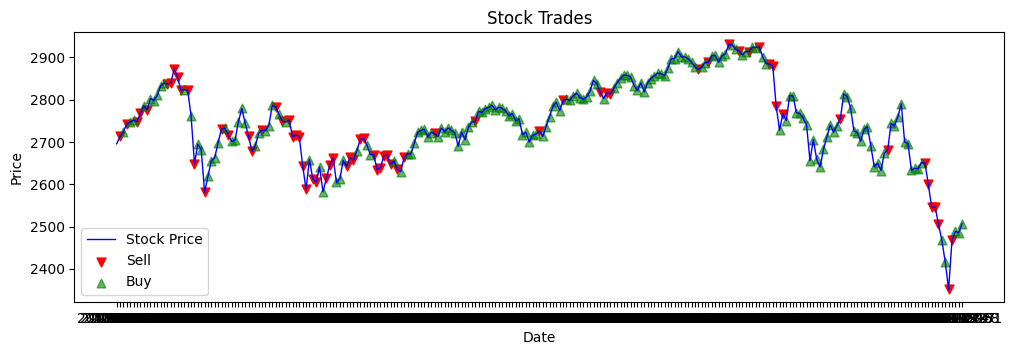

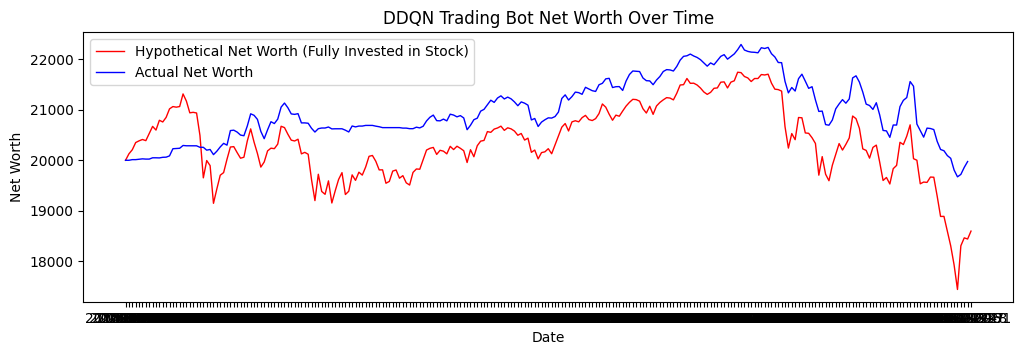

Time: 100 episode: 8/20 score: 19233.41611160855
Time: 200 episode: 8/20 score: 19451.96390925737
Episode 8/20 - NetWorth: 17573.595953548807


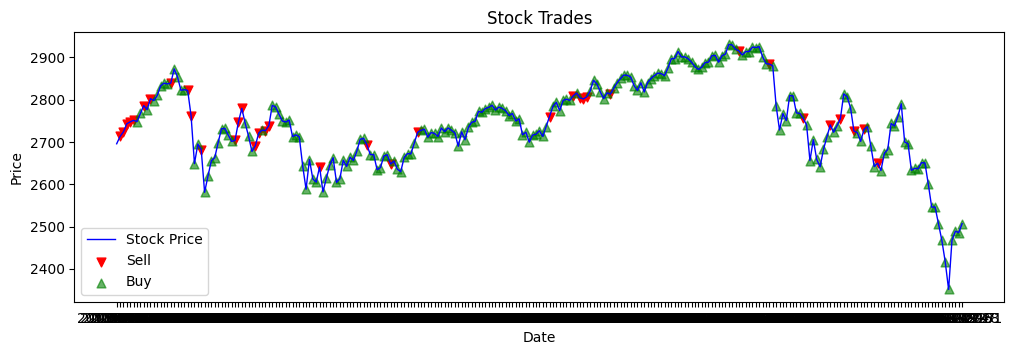

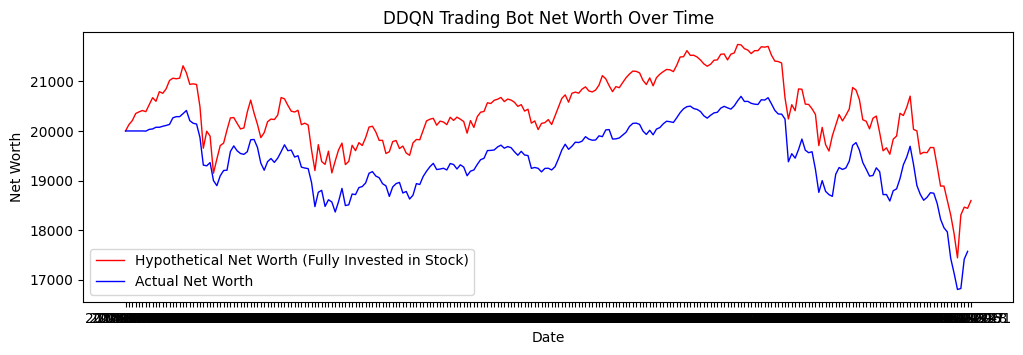

Time: 100 episode: 9/20 score: 19878.78997580926
Time: 200 episode: 9/20 score: 20100.559685727756
Episode 9/20 - NetWorth: 18617.934953126627


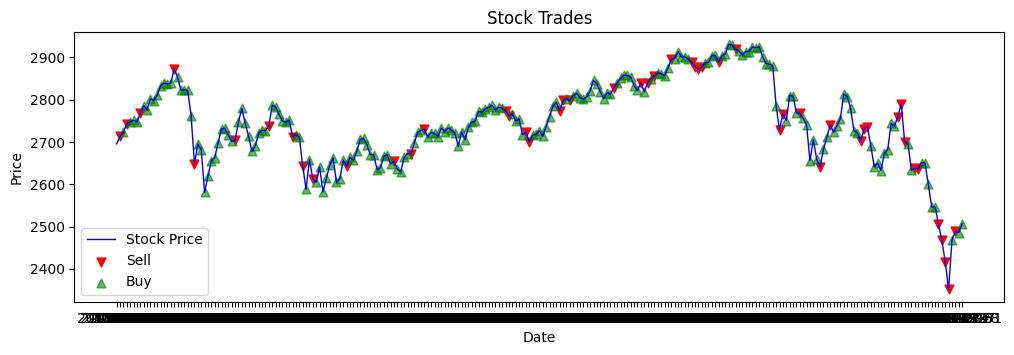

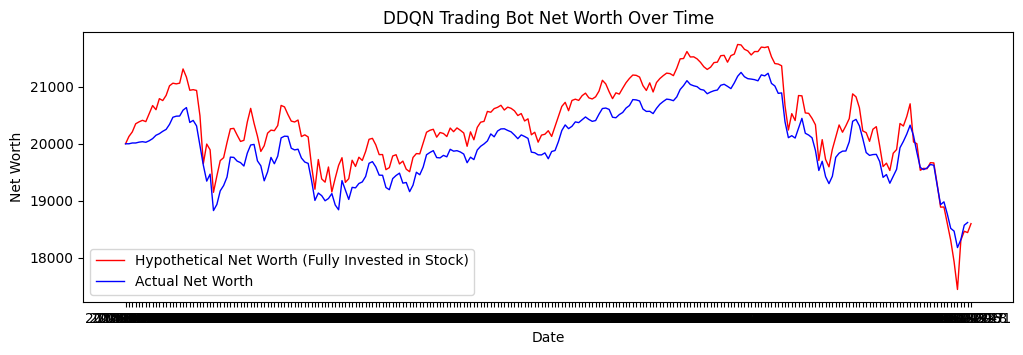

Time: 100 episode: 10/20 score: 20176.586343156134
Time: 200 episode: 10/20 score: 20223.723049462424
Episode 10/20 - NetWorth: 19336.367658618987


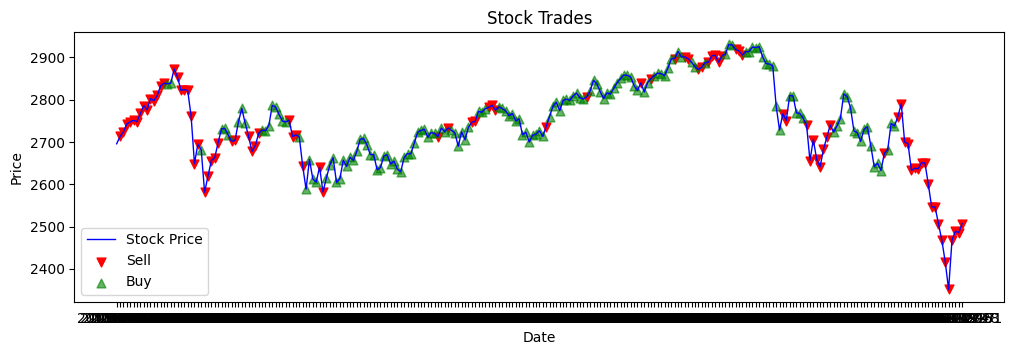

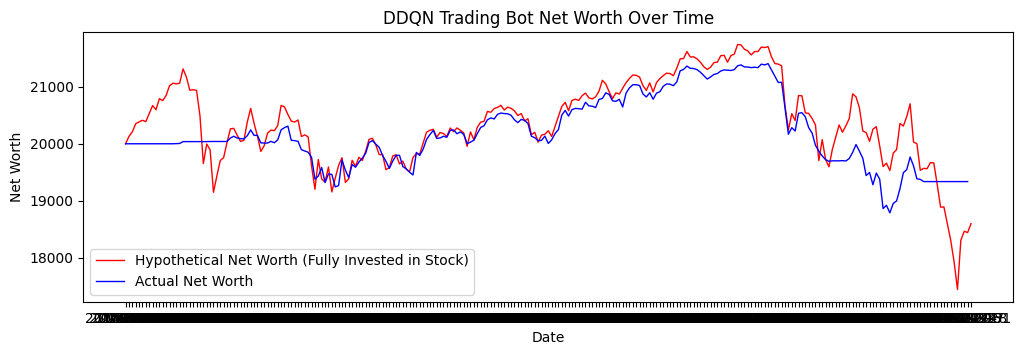

Time: 100 episode: 11/20 score: 19935.82118467416
Time: 200 episode: 11/20 score: 20127.4185323566
Episode 11/20 - NetWorth: 19668.722557758505


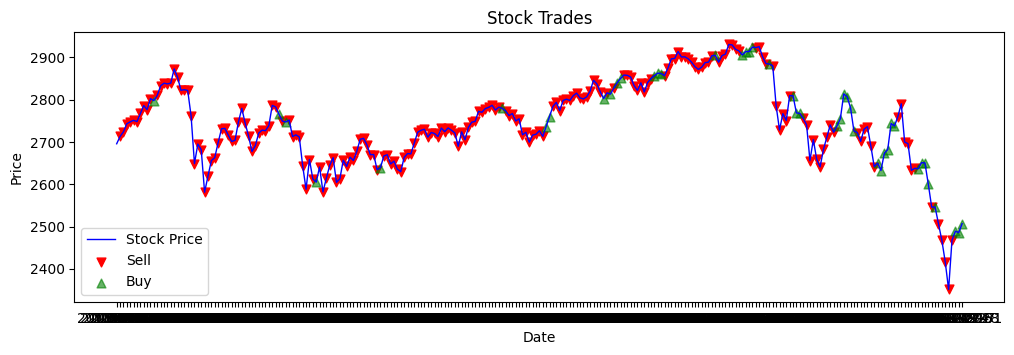

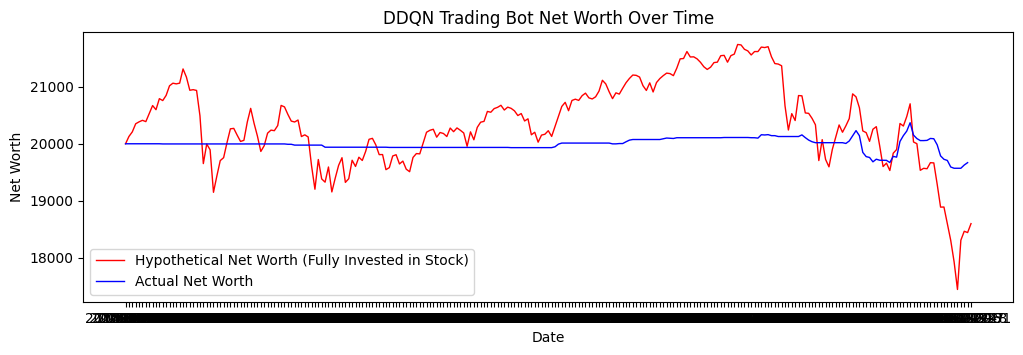

Time: 100 episode: 12/20 score: 20103.798445529086
Time: 200 episode: 12/20 score: 20289.97631922595
Episode 12/20 - NetWorth: 18538.917405438


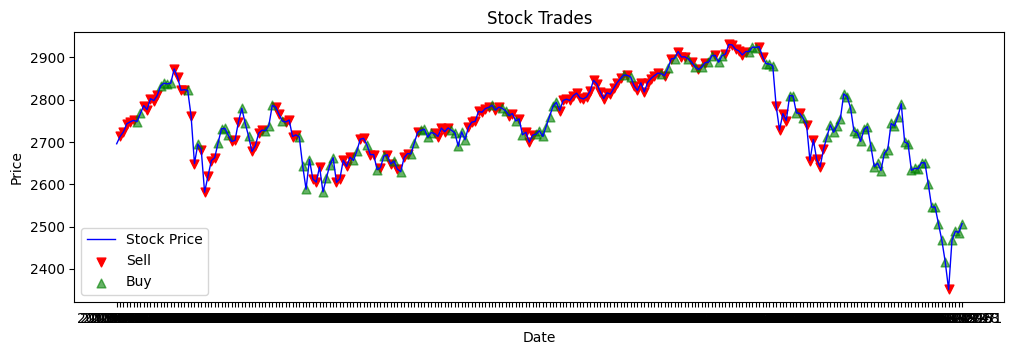

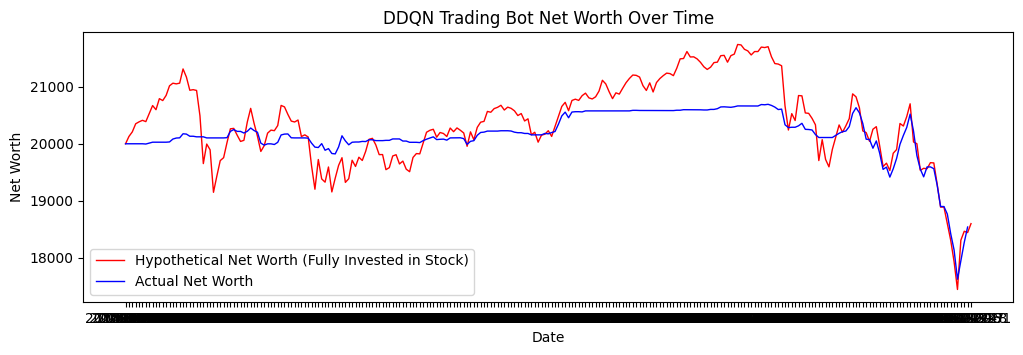

Time: 100 episode: 13/20 score: 20346.420924837985
Time: 200 episode: 13/20 score: 20515.139621551043
Episode 13/20 - NetWorth: 20660.89200276121


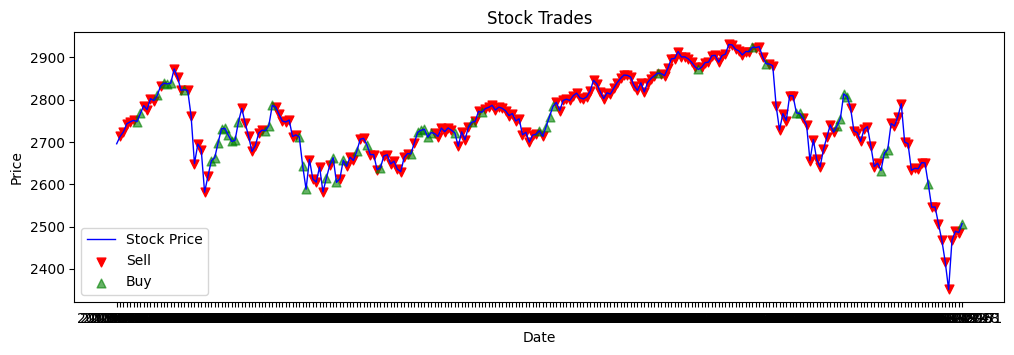

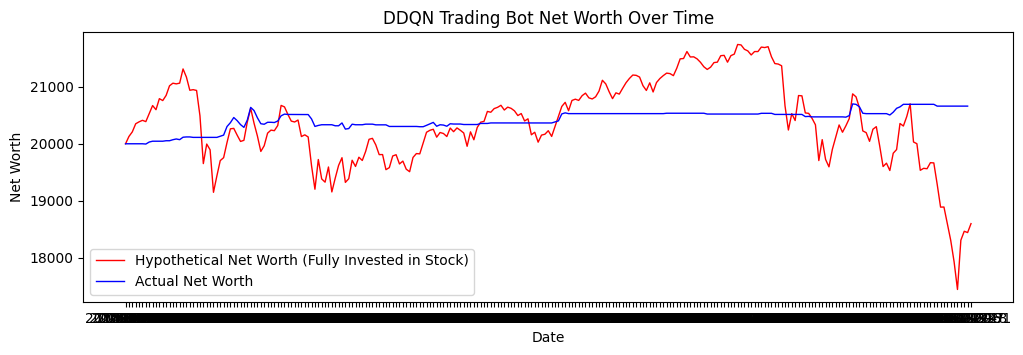

Time: 100 episode: 14/20 score: 19996.19663055068
Time: 200 episode: 14/20 score: 20240.49095739083
Episode 14/20 - NetWorth: 20156.118637027168


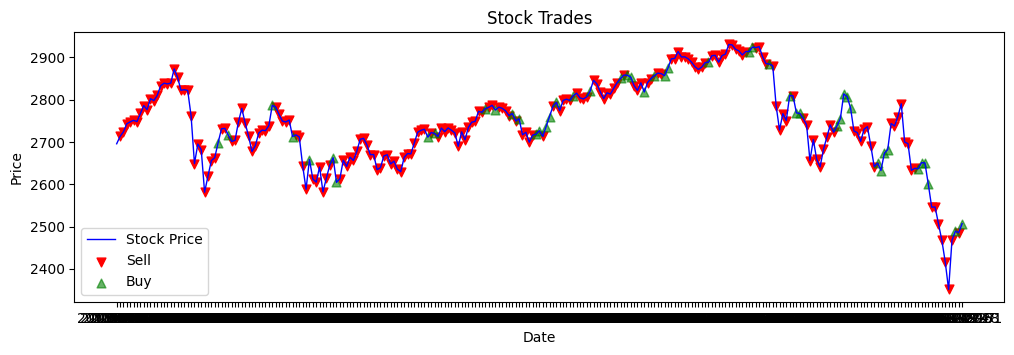

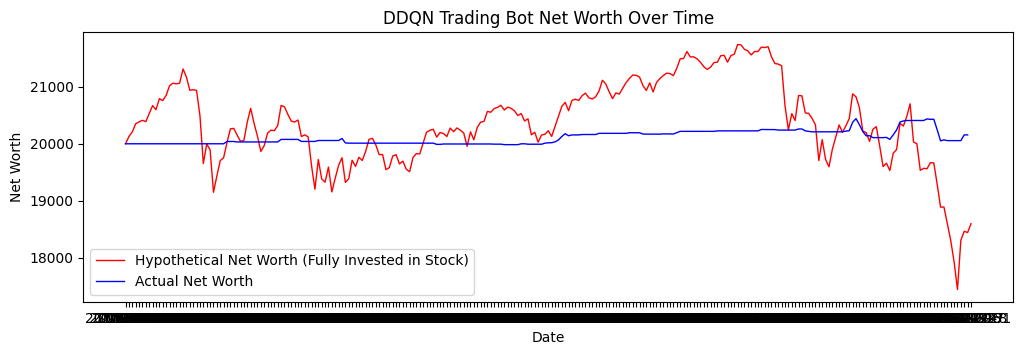

Time: 100 episode: 15/20 score: 20364.536879542018
Time: 200 episode: 15/20 score: 20748.981958440527
Episode 15/20 - NetWorth: 20593.169485717204


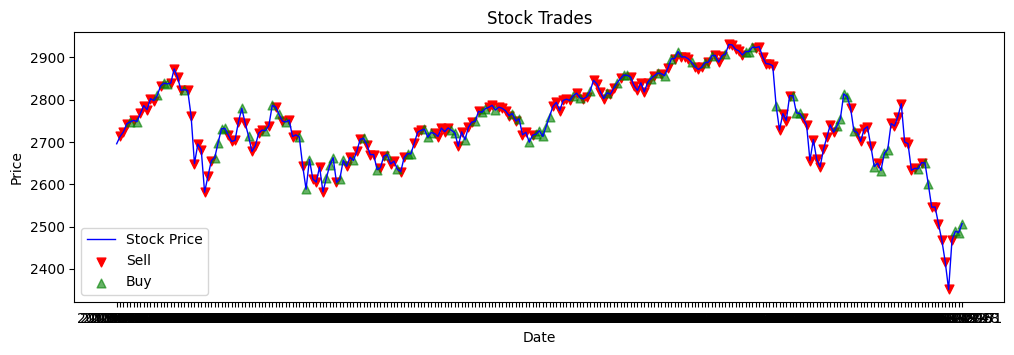

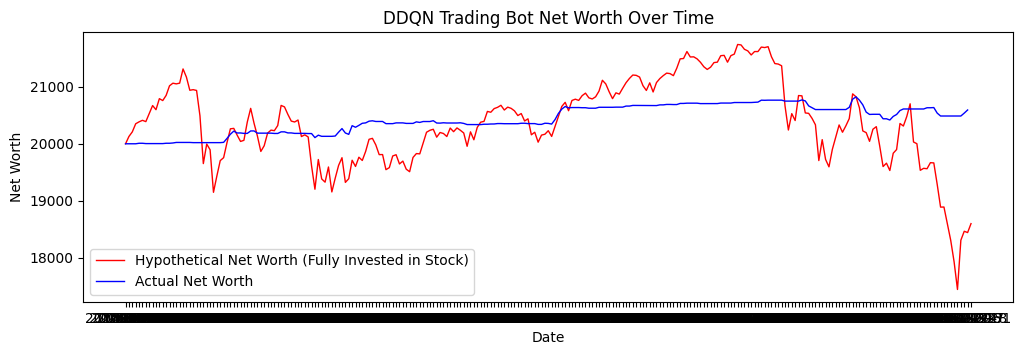

Time: 100 episode: 16/20 score: 20048.36631006626
Time: 200 episode: 16/20 score: 20129.86464867439
Episode 16/20 - NetWorth: 20123.539184020465


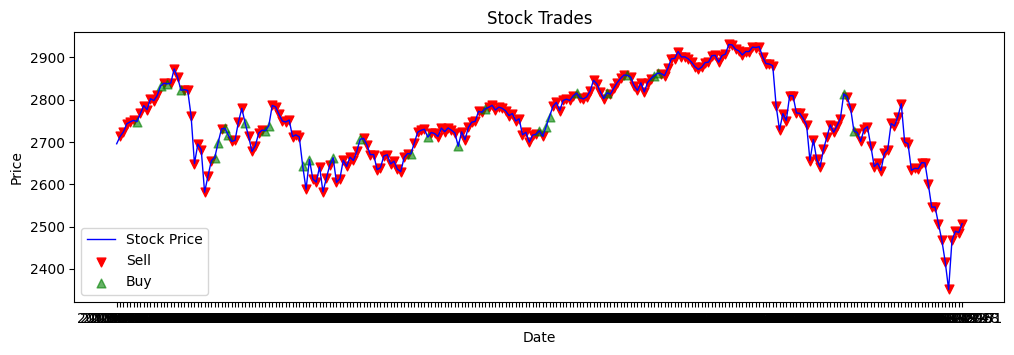

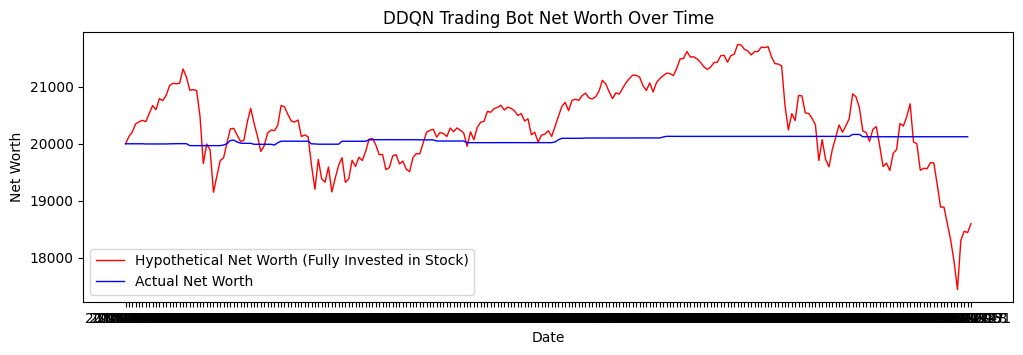

Time: 100 episode: 17/20 score: 20184.20277960154
Time: 200 episode: 17/20 score: 20520.037128356213
Episode 17/20 - NetWorth: 19111.033612490486


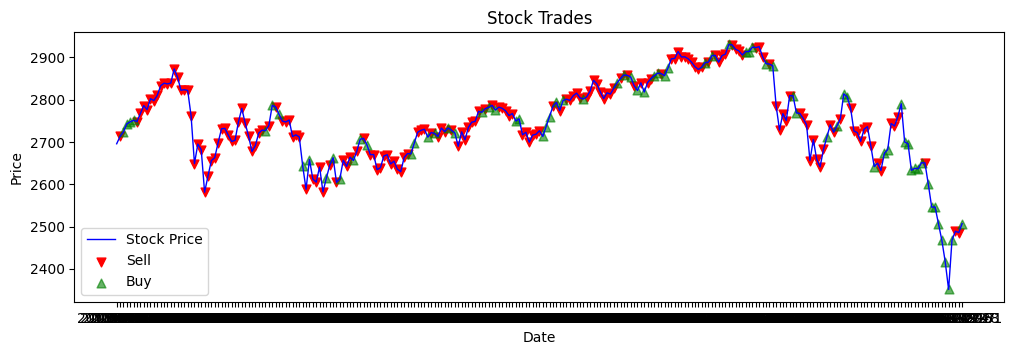

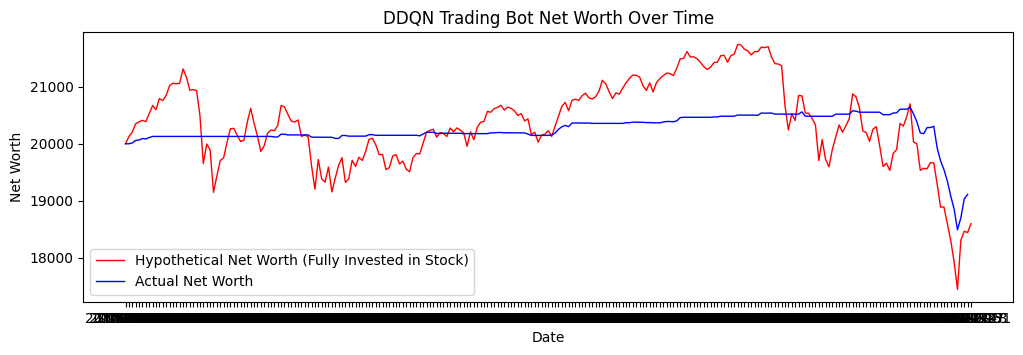

Time: 100 episode: 18/20 score: 20308.12532879266
Time: 200 episode: 18/20 score: 20565.170642650355
Episode 18/20 - NetWorth: 20706.631414550247


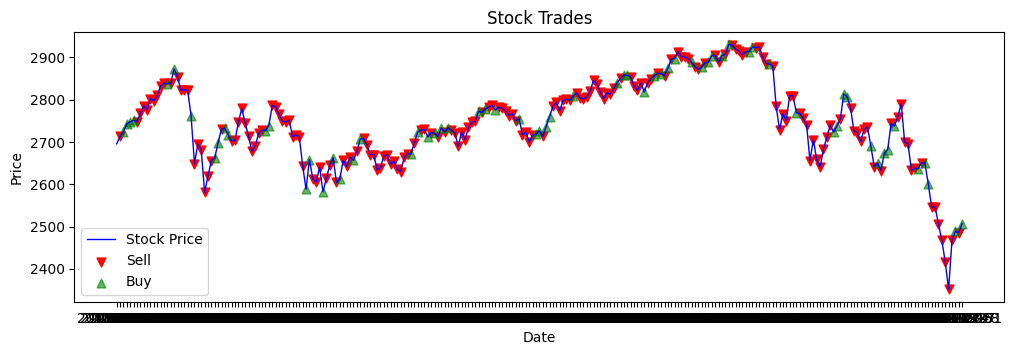

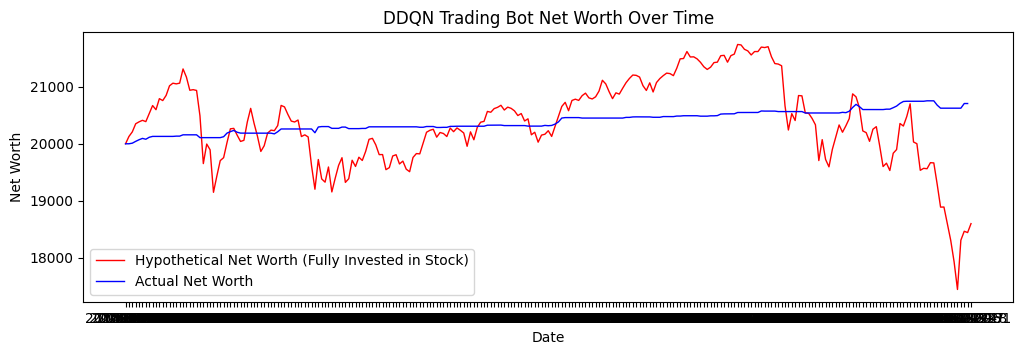

Time: 100 episode: 19/20 score: 20343.332493973034
Time: 200 episode: 19/20 score: 20546.52763240564
Episode 19/20 - NetWorth: 20537.443440563708


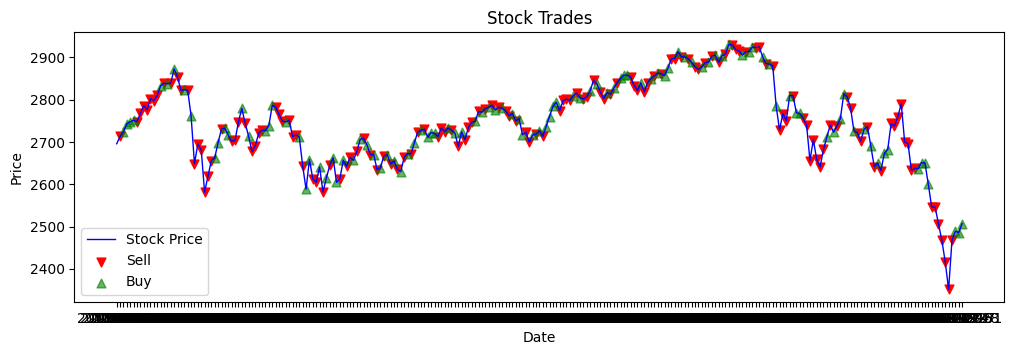

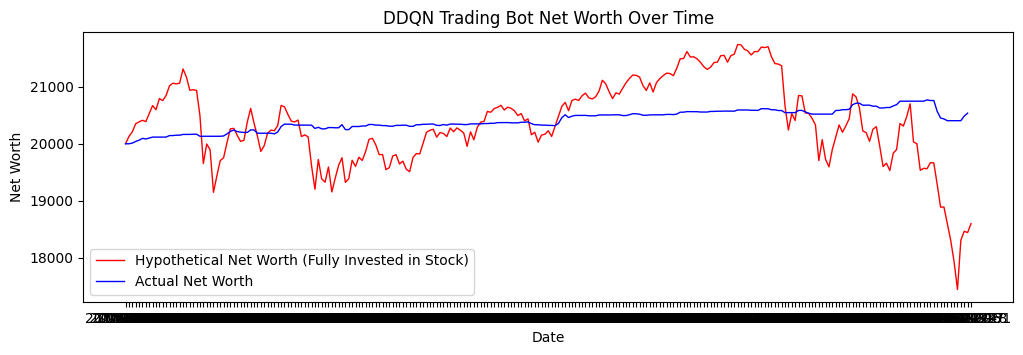

Time: 100 episode: 20/20 score: 20674.748318884536
Time: 200 episode: 20/20 score: 21042.363155890318
Episode 20/20 - NetWorth: 21001.06459924012


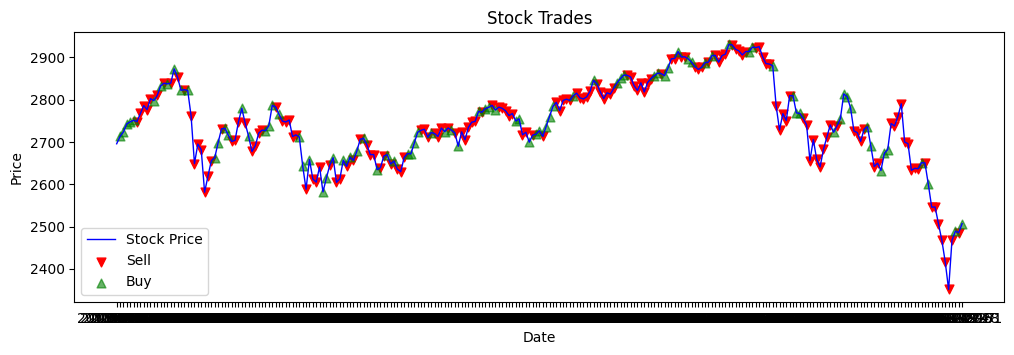

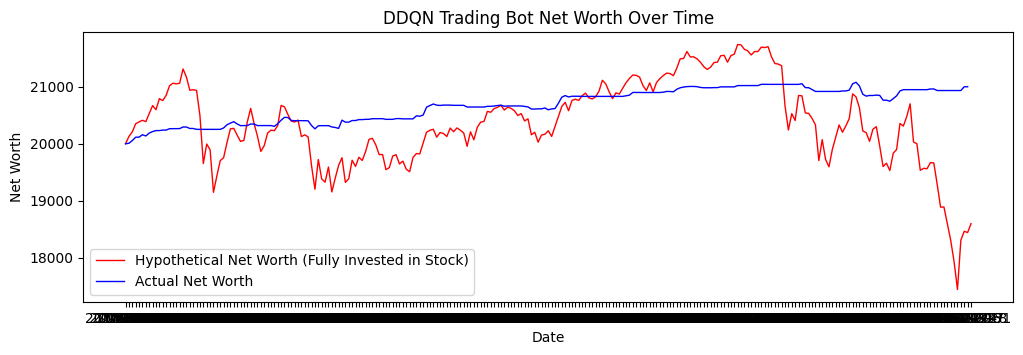

In [14]:
networths = []
for e in range(episodes):
    state = env.reset()
    state = state.flatten()  # Flatten the state to match the input dimensions of the network
    done = False
    trades = []
    networth = []
    for time in range(1,len(env.df)):
        if(time % 100 == 0):
            print(f"Time: {time} episode: {e+1}/{episodes} score: {env.net_worth}")
        action = agent.act(state)
        next_state, reward, done= env.step(action)
        next_state = next_state.flatten()  # Flatten the next state
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        trades.append((env.current_step, action))  # Log the trade action
        if done:
            agent.update_target_model()
            break
        agent.replay()
        networth.append(env.net_worth)
    print(f'Episode {e+1}/{episodes} - NetWorth: {env.net_worth}')
    networths.append(env.net_worth)
    plot_buy_sell(env,trades)
    plot_networth(env,networth)
    if (e + 1) % 10 == 0:
        agent.save(f"model_ddqn_{e+1}")
    agent.save("model_ddqn_temp")

[19875.350771953676, 19795.19884724588, 18384.441900295446, 19139.502190417035, 20392.58324534669, 18597.604274762045, 19975.285107765492, 17573.595953548807, 18617.934953126627, 19336.367658618987, 19668.722557758505, 18538.917405438, 20660.89200276121, 20156.118637027168, 20593.169485717204, 20123.539184020465, 19111.033612490486, 20706.631414550247, 20537.443440563708, 21001.06459924012]


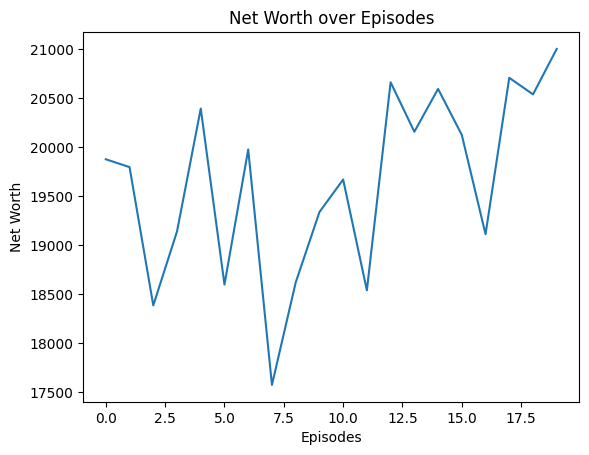

In [15]:
print(networths)
# Plotting the net worth over episodes
plt.plot(range(episodes), networths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()

[19875.350771953676, 19795.19884724588, 18384.441900295446, 19139.502190417035, 20392.58324534669, 18597.604274762045, 19975.285107765492, 17573.595953548807, 18617.934953126627, 19336.367658618987, 19668.722557758505, 18538.917405438, 20660.89200276121, 20156.118637027168, 20593.169485717204, 20123.539184020465, 19111.033612490486, 20706.631414550247, 20537.443440563708, 21001.06459924012]


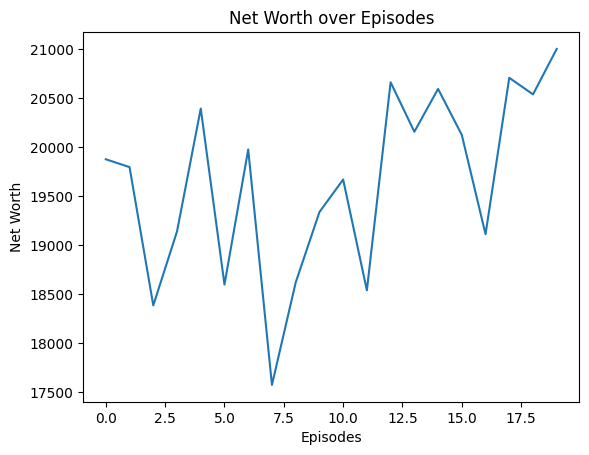

In [ ]:
print(networths)
# Plotting the net worth over episodes
plt.plot(range(episodes), networths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()

With episodes it is clearly visible that the avergage networth recieved it better

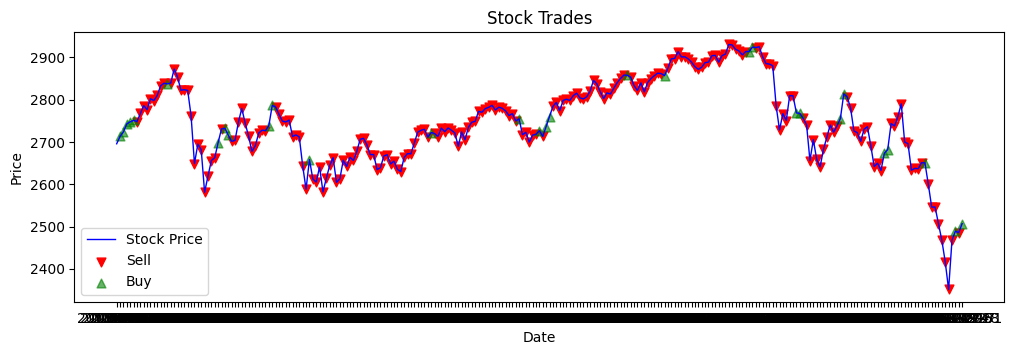

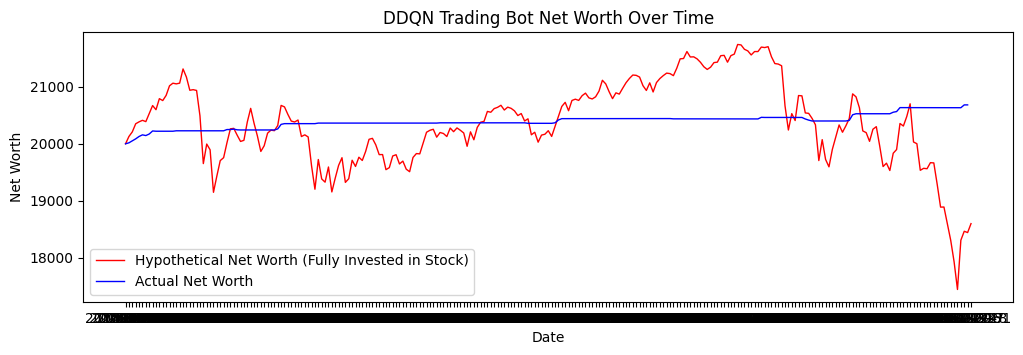

Episode 1/5 - Net Worth: 20682.49397255182


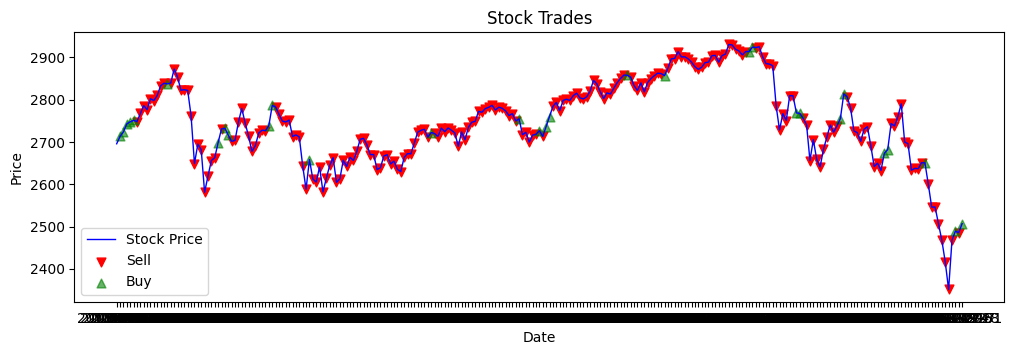

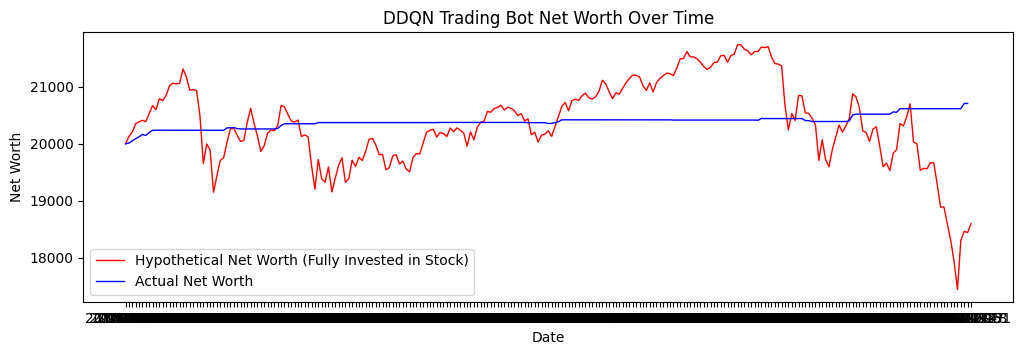

Episode 2/5 - Net Worth: 20707.159797312233


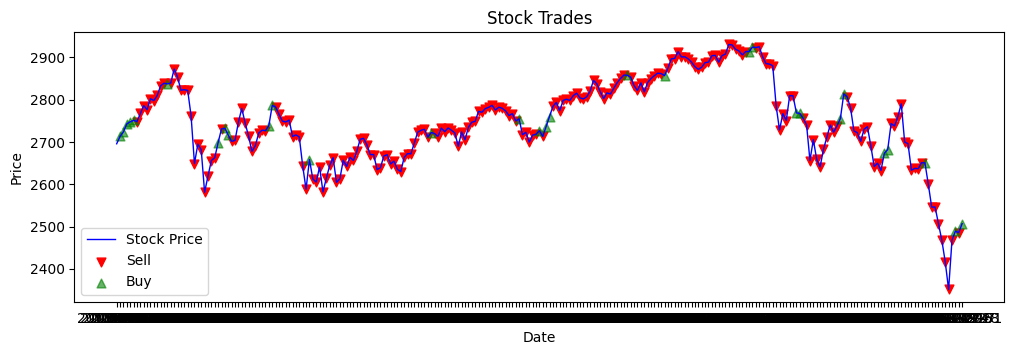

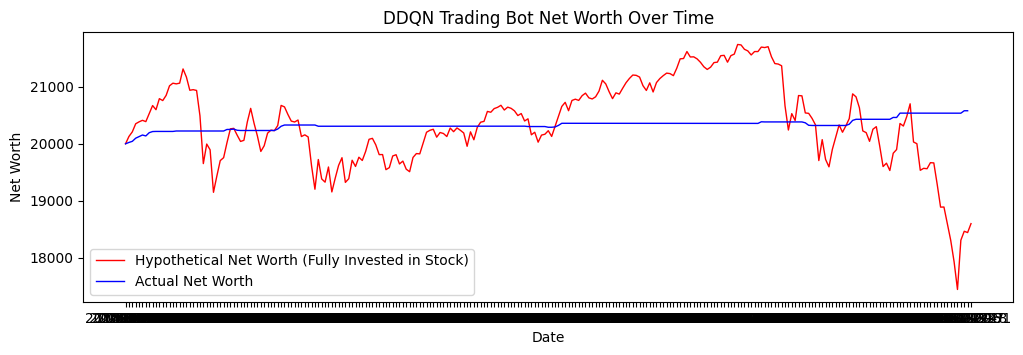

Episode 3/5 - Net Worth: 20579.617895789434


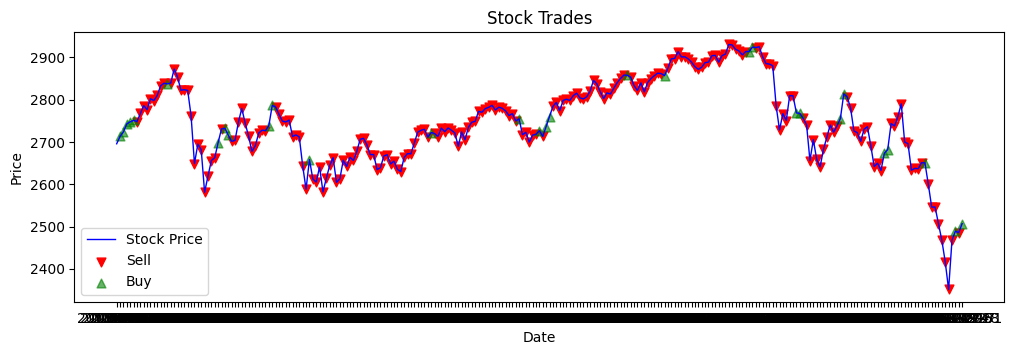

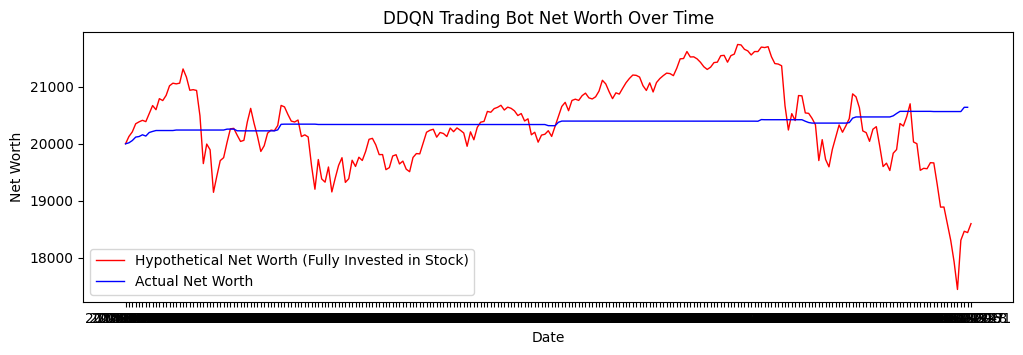

Episode 4/5 - Net Worth: 20640.313410968578


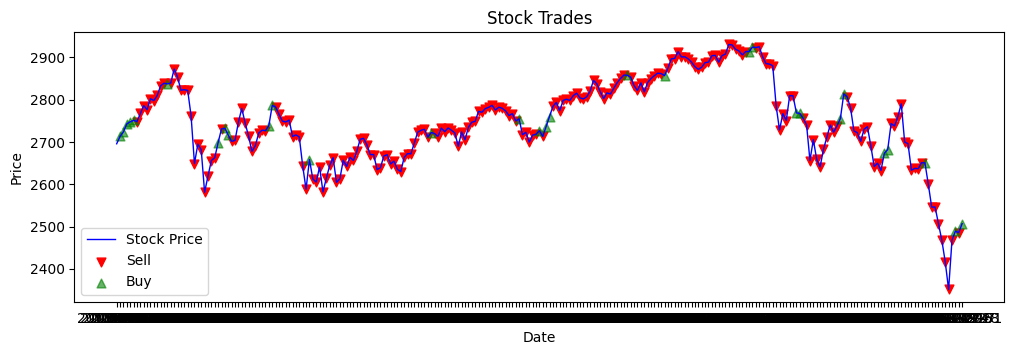

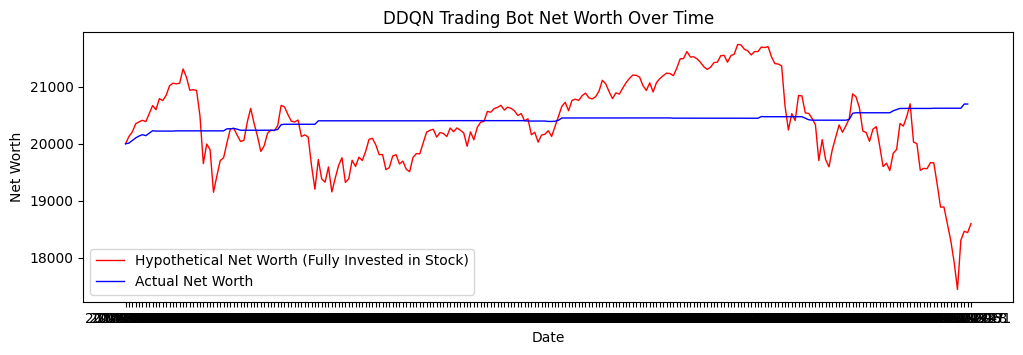

Episode 5/5 - Net Worth: 20697.61680036455
Average net worth over 5 episodes: 20661.440375397324


In [16]:
# Evaluation
def evaluate(env, agent, episodes=1):
    final_net_worths = []
    # total_rewards = 0
    for e in range(episodes):
        trades = []
        state = env.reset()
        state = state.flatten()
        networth = []
        for time in range(1,len(env.df)):
            action = agent.act(state)
            next_state, reward, done= env.step(action)
            trades.append((env.current_step, action))  # Log the trade action
            next_state = next_state.flatten()
            # total_rewards += reward
            state = next_state
            if done:
                break
            networth.append(env.net_worth)
        plot_buy_sell(env,trades)
        plot_networth(env,networth)
        final_net_worths.append(env.net_worth)
        print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')
        
    print(f"Average net worth over {episodes} episodes: {sum(final_net_worths)/episodes}")
    

# Evaluate the agent
# agent = Agent(state_dim=state_dim)
agent = Agent(state_dim=state_dim,is_eval=True, model_name="model_ddqn_temp.pth")
evaluate(env, agent)
# plt.savefig('saved_visuals/dqn_eval1.jpeg')